<a href="https://github.com/isb-cgc/ML-Develop/tree/main/notebooks/SyntheticData/SyntheticExpressionDataSDV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Synthetic Gene Expression Data Using Synthetic Data Vault

Check out other ML/AI notebooks at [ML-Develop Repository](https://github.com/isb-cgc/ML-Develop/tree/main/notebooks)!

```
Title: Generating Synthetic Gene Expression Data Using Synthetic Data Vault  
Author: Jacob Wilson  
Created: 2025-06-06
URL: https://github.com/isb-cgc/ML-Develop/tree/main/notebooks/SyntheticData/SyntheticExpressionDataSDV  
Purpose: We will use the Python library Synthetic Data Vault (SDV) to generate synthetic gene expression data using TCGA as the source.
```

Synthetic Data Vault (SDV) is an extensive Python library that helps users create synthetic tabular data. It utilizes machine learning and statistical methods to model the structure and statistical nature of a given dataset. For more information, see the documentation provided for Synthetic Data Vault, [https://docs.sdv.dev/sdv](https://docs.sdv.dev/sdv).

## Install the SDV Python library

In [1]:
%pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.2/180.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

## Initialize Notebook Environment

Before beginning, we first need to load dependencies and authenticate to BigQuery.

## Install Dependencies

In [2]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# SDV libraries
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot

from itertools import chain

## Authenticate

In order to utilize BigQuery, we must obtain authorization to BigQuery and Google Cloud.

In [4]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

## Google project ID

Set your own Google project ID for use with this notebook.

In [5]:
# set the google project that will be billed for this notebook's computations
google_project = 'your_project_id'  ## change this

## BigQuery Client

In [6]:
# Initialize a client to access the data within BigQuery
if google_project == 'your_project_id':
    print('Please update the project ID with your Google Cloud Project')
else:
    client = bigquery.Client(google_project)

# set the TCGA project
TCGA_proj = 'isb-cgc-bq'
TCGA_data = 'TCGA_versioned'

# set the Mitelman Database project
mitel_proj = 'mitelman-db'
mitel_data = 'prod'

## Preparing the Real Data

### Select gene names for prostate cancer cases in the Mitelman Database

In [7]:
# query for the ten most common gene fusions for Mitelman Prostate adenocarcinoma cases
fusions_prostate = f'''
SELECT g.Gene, count(g.Gene) AS Count, m.Morph, k.Benamning, m.Topo
FROM `{mitel_proj}.{mitel_data}.MolClinGene` g
JOIN `{mitel_proj}.{mitel_data}.MolBiolClinAssoc` m
  ON m.RefNo = g.RefNo AND m.InvNo = g.InvNo
JOIN `{mitel_proj}.{mitel_data}.Koder` k
  ON k.Kod = m.Topo AND k.kodTyp = "TOP"
-- we are only considering gene fusions for Prostate adenocarcinoma
WHERE g.Gene LIKE "%::%" AND m.Morph LIKE "3111" AND m.Topo LIKE "0602"
GROUP BY g.Gene, m.Morph, k.Benamning, m.Topo
ORDER BY Count DESC
LIMIT 10
'''

In [8]:
# run the query and view the gene fusions
top10_prostate = client.query(fusions_prostate).result().to_dataframe()
#print(top10_prostate)

In [9]:
# convert the list of gene fusion pairs into a string containing individual unique gene names
genes_list = [x.split("::") for x in top10_prostate['Gene']]
genes_set = set(chain.from_iterable(genes_list))
genes_str = ','.join(f"'{gene}'" for gene in genes_set)

#print(genes_str)

### Select prostate cancer cases in TCGA

In [10]:
# query to select all Prostate adenocarcinomas in TCGA
query_TCGA = f'''
SELECT r.project_short_name,
      r.primary_site,
      r.gene_name,
      p.proj__name,
      p.disease_type,
      p.diag__primary_gleason_grade
FROM `{TCGA_proj}.{TCGA_data}.RNAseq_hg38_gdc_r39` r
JOIN `{TCGA_proj}.{TCGA_data}.clinical_gdc_r39` p
  ON r.case_gdc_id = p.case_id
-- select cases from the Prostate adenocarcinoma project
WHERE r.project_short_name = "TCGA-PRAD"
  AND p.disease_type = "Adenomas and Adenocarcinomas"
'''

In [11]:
# run the query and view results
TCGA_prostate = client.query(query_TCGA).result().to_dataframe()
#print(TCGA_prostate)

### Create a table of real data containing gene expression data of our 10 genes from TCGA prostate cancer cases

In [12]:
# query to select all TCGA gene expression data for our 10 genes
real_data_query = f'''
SELECT * FROM(
  SELECT
    seq.case_barcode,
    seq.gene_name,
    seq.fpkm_uq_unstranded,
    --assign Primary Gleason Grade to an appropriate integer
    CASE clin.diag__primary_gleason_grade
      WHEN "Pattern 1" THEN 1
      WHEN "Pattern 2" THEN 2
      WHEN "Pattern 3" THEN 3
      WHEN "Pattern 4" THEN 4
      WHEN "Pattern 5" THEN 5
    END AS primary_gleason_grade
  FROM `{TCGA_proj}.{TCGA_data}.RNAseq_hg38_gdc_r39` seq
  JOIN `{TCGA_proj}.{TCGA_data}.clinical_gdc_r39` clin
    ON seq.case_gdc_id = clin.case_id
  WHERE seq.project_short_name = "TCGA-PRAD"
    AND clin.disease_type = "Adenomas and Adenocarcinomas")
--transform genes from rows to columns using pivot
PIVOT(MAX(fpkm_uq_unstranded) for gene_name IN ({genes_str}))
'''
#print(real_data_query)

In [13]:
# Run the query.
real_data = client.query(real_data_query).result().to_dataframe()
print(real_data)

     case_barcode  primary_gleason_grade      ETV4  SERINC5  METTL13      AK5  \
0    TCGA-FC-A8O0                      3    2.3907   9.0659      NaN   0.8539   
1    TCGA-M7-A720                      3    1.3257  30.4393      NaN   1.0580   
2    TCGA-CH-5763                      3  115.9199  50.1531      NaN   1.5347   
3    TCGA-FC-7961                      4    0.5355  15.4432      NaN   2.3802   
4    TCGA-CH-5761                      5    0.6629  35.0183      NaN   0.4997   
..            ...                    ...       ...      ...      ...      ...   
482  TCGA-VP-AA1N                      5    0.5139  12.1202      NaN  19.4430   
483  TCGA-HC-7737                      3    0.5249  23.0455      NaN   1.6228   
484  TCGA-G9-A9S7                      4    0.3071  32.1440      NaN   3.4087   
485  TCGA-KK-A6DY                      3    0.3327  48.9531      NaN   3.5293   
486  TCGA-HC-7081                      4    0.4576  80.9899      NaN   6.2830   

      SLC45A3   OSBPL9   TM

## Using SDV to Generate Synthetic Data

### Create the metadata for the real data

In [14]:
metadata = Metadata.detect_from_dataframe(
    data=real_data,
    table_name='tcga_data')

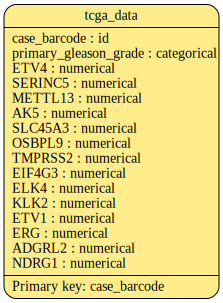

In [15]:
metadata.visualize()

### Initialize the synthesizer and fit the real data

In [16]:
# create a synthesizer object, in this case we utilize a copula for our single table of data
synthesizer = GaussianCopulaSynthesizer(metadata)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:128: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [17]:
# fit the real data
synthesizer.fit(
   data=real_data
)

In [18]:
# generate 500 rows of synthetic data
synthetic_data = synthesizer.sample(
    num_rows=500
)

synthetic_data.head()

,case_barcode,primary_gleason_grade,ETV4,SERINC5,METTL13,AK5,SLC45A3,OSBPL9,TMPRSS2,EIF4G3,ELK4,KLK2,ETV1,ERG,ADGRL2,NDRG1
0,sdv-id-hpNZfH,4,0.7308,25.3137,NaN,1.3841,417.5141,9.8846,137.7276,4.4592,6.5369,1204.8922,9.7314,1.5438,1.0246,202.9782
1,sdv-id-xvUQmC,4,1.8839,92.7804,NaN,1.6367,522.3375,11.2926,309.2774,6.4824,9.5247,1090.3545,0.7470,23.2429,4.0630,241.9447
2,sdv-id-EDPSRY,3,0.0707,52.8415,NaN,1.7435,706.6449,8.6002,583.7457,11.5639,12.6124,2028.5618,2.4795,21.5101,2.5362,131.1099
3,sdv-id-pYIgsB,3,3.7638,34.1563,NaN,0.8234,355.2948,12.6054,101.5045,12.2717,18.8942,1098.7766,5.5499,15.5737,2.1694,166.4092
4,sdv-id-ygkCvT,5,0.1449,14.4834,NaN,11.7325,770.3939,8.8703,388.7911,6.6172,14.5575,2022.4814,0.1354,2.2369,1.9922,34.5570


### Evaluate the synthetic data using the SDV tools

In [19]:
# run diagnostics
diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 16/16 [00:00<00:00, 736.53it/s]|
Data Validity Score: 100.0%



/usr/local/lib/python3.11/dist-packages/sdmetrics/single_column/statistical/boundary_adherence.py:58: RuntimeWarning: invalid value encountered in scalar divide
  return valid.sum() / len(synthetic_data)


(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 151.15it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [20]:
# evaluate quality
quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 16/16 [00:00<00:00, 472.35it/s]|
Column Shapes Score: 85.67%



/usr/local/lib/python3.11/dist-packages/sdmetrics/single_column/statistical/kscomplement.py:68: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  statistic, _ = ks_2samp(real_data, synthetic_data)


(2/2) Evaluating Column Pair Trends: |██████████| 120/120 [00:00<00:00, 205.21it/s]|
Column Pair Trends Score: 95.24%

Overall Score (Average): 90.46%



### Plot the results to compare synthetic and real data distributions

In [21]:
# compare Gleason grade data
fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='primary_gleason_grade',
    metadata=metadata
)

fig.show()

In [22]:
# compare ERG expression data
erg_fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='ERG',
    metadata=metadata
)

erg_fig.show()

In [23]:
# compare TMPRSS2 expression data
tmprss2_fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='TMPRSS2',
    metadata=metadata
)

tmprss2_fig.show()